##  BIAS ! Don't be looking for your inversion to FIX it !

Well characterized random errors can be accommodated in an inversion framework but inherent bias in the forward model or observations can not be corrected for in the inversion. Here we present three different biases that have been shown to emerge in the OCO2MIP project (Crowell et al 2019, Piero et al 2022) and provide bias estimates for two (N Africa obs bias and Ocean Glint obs bias) to test the effects on the flux estimates.

### The North African OCO-2 Bias?

## 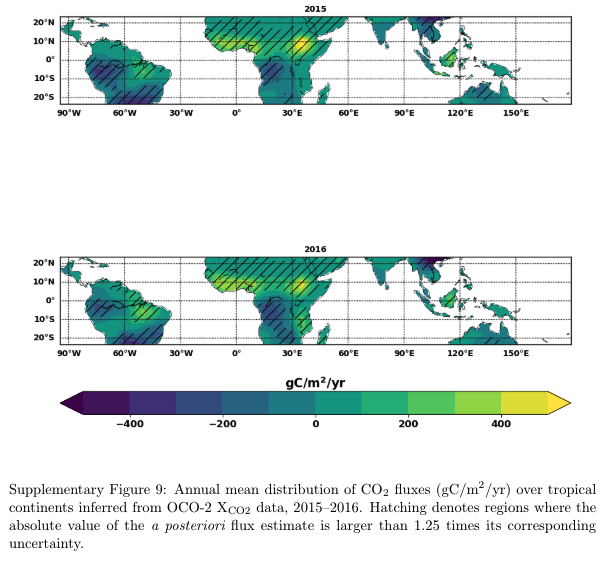

The column average CO2, XCO2, from the OCO-2 data has been hypothesized to be biased over a few areas of the world due to different conditions which make retrievals difficult.  One particular location which is difficult is N. Africa where both albedo and frequent dust/aerosols should theoretically make retreivals more difficult.  Palmer et al 2019 hypothesized that the data was unbiased and produced what would seem to be unreasonably large sources of CO2 out of Northern Africa.  We can investigate the difference between a possible bias and flux estimates in this notebook.


### Atmospheric Transport Variability 

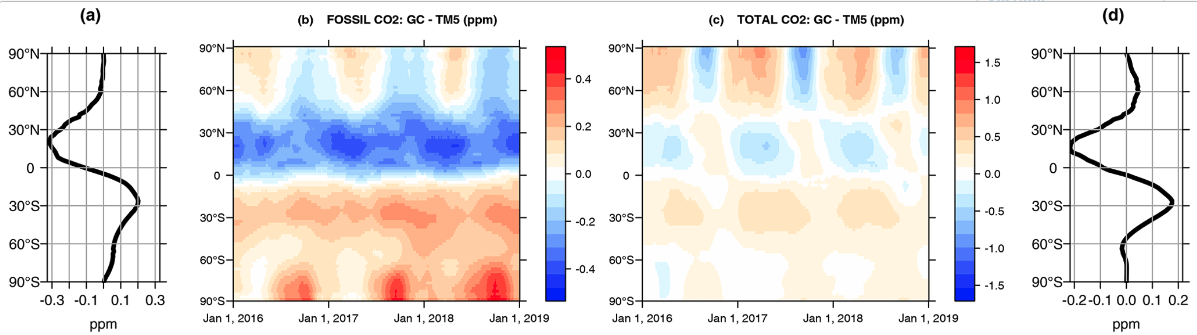

The above image shows the difference in pressure weighted column average CO2, XCO2, between two forward model runs (TM5 and GEOS-Chem) with the same realistic CO2 fluxes (Schuh et al 2019,2024). This difference is what one might expect to be termed "transport error" in a global model, relative to the CO2 problem.  Note that convolution over a relatively 'constant in time' emission like fossil fuels generates a 'constant in time' bias, while the transport different over a seasonally varying bias which is part of the total flux in the right hand image results in a seasonally varying bias in XCO2. 

### A Possible Ocean Glint bias from OCO-2 ?

<div>
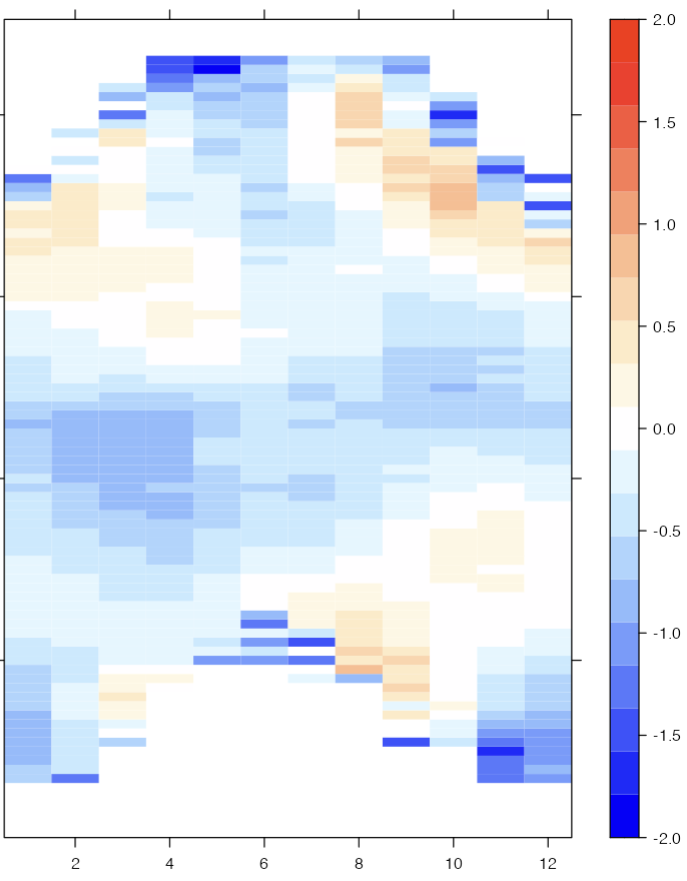
</div>

The above image shows what appears to be a likely bias in retrieved OCO-2 XCO2 over ocean surfaces that is currently being investigated.  By comparing satellite observations to models (as truth), several have hypothesized that the above differences might represent a possible bias in ocean glint retrievals.

### Other Possible Biases, in situ flask bias?
NOAA/GML has found that CO2 concentration can be artificially reduced when air samples with high water vapour (>1.7%) are pressurized in programmable flask package (PFP) flasks to 2.7 bar, as a result of condensation. This could present a significant bias in near surface observations taken with PFP system.  We don't have estimates for this as of y

### Moving Forward...
In this notebook, let's play with adding biases to the OCO-2 XCO2 simulated observations and invert them to determine the sensitivity of the inversion results to systematic biases that can not be corrected for in the inversion.

Let these questions guide you a bit...

- Run the “bias over N. Africa case”, the first of the two biases    - What is effect on annual flux estimate over N. Africa ?
    - What is effect over globe
    - Are there other regions impacted by this bias besides N. Africa, where the bias occurs?  Any thoughts why?
>       
- Run the “bias over Ocean Glint observations”, the second of the two biases
    - In general, how does this bias affect the ocean regions vs the land regions
>
- Can you think of a way, within the inversion framework that you might mitigate this and “force” the inversion towards your priors assuming you think they are "correct" and don't want them influenced by a "bias"? 


In [ ]:
####################################################################
#  THIS CELL IS ALL SETUP FOR EACH OF THE NOTEBOOKS
####################################################################

#-- Look for locally installed packages on NASA JupyterHub Resources
.libPaths(new=c("/home/rstudio/shared/lib/R-4.3/x86_64-pc-linux-gnu",.libPaths())) 
.libPaths()

if(Sys.getenv("AWS_WEB_IDENTITY_TOKEN_FILE") == ""){
 code_dir <- "/projects/ssim-ghg-2024/"
 data_dir <-  "/Users/aschuh/SSIM-GHG/data/"
 output_dir <- "~/temp/output/"
 }else{
 code_dir <-  "~/ssim-ghg-2024/"
 data_dir <-  "~/shared/ssim-ghg-data/inversion_examples/"
 output_dir <- "../../output/"
 }

Rcode_dir <- file.path(code_dir,"batch/")

setwd(Rcode_dir)

#######################################################
#-- ***Parent Directory and code for ALL inversions***
#######################################################
###############################################
#-- Load Code
##############################################
source(file.path(Rcode_dir,"util_code_032024.R"))
source(file.path(Rcode_dir,"plot_concentrations.R"))
source(file.path(Rcode_dir,"inversion_032024.R"))
source(file.path(Rcode_dir,"write_inversion_2_netcdf_032024.R"))
source(file.path(Rcode_dir,"generate_transcom_flux_ensemble_from_inversion.R"))
       
###############################################
#-- Required Libraries
###############################################
require(ncdf4,warn.conflicts = FALSE)
require(plyr,warn.conflicts = FALSE)
require(dplyr,warn.conflicts = FALSE)
require(parallel,warn.conflicts = FALSE)
require(ggplot2,warn.conflicts = FALSE)
require(abind,warn.conflicts = FALSE)
require(Matrix,warn.conflicts = FALSE)
require(lattice,warn.conflicts = FALSE)
require(memuse,warn.conflicts = FALSE)
require(EnvStats,warn.conflicts = FALSE)
require(gridExtra,warn.conflicts = FALSE)
require(mvtnorm,warn.conflicts = FALSE)
require(plotly,warn.conflicts = FALSE)

########################
#--  Detect Cores
########################
print(paste("Num CPUs:",detectCores(),"cores"))
memuse::Sys.meminfo()

#### Baseline Sensitivity Matrices

These precalculated sensitivity matrices (jacob object) detail the sensitivity of 1,156,383 different observations to the basis functions, which consist of 22 regions, 11 land and 11 ocean, as well as 24 months. The jacob_bgd object consists of the sensitivity of the observations to emission sources which will not be optimized here, particularly fire emissions (e.g. forest/grassland fires) and fossil fuel emissions.

In [ ]:
###############################################
#--  Load sensitivity matrices 
###############################################

load(file.path(data_dir,"jacobians/","trunc_full_jacob_030624_with_dimnames_sib4_4x5_mask.rda"))
load(file.path(data_dir,"jacobians/","jacob_bgd_060524.rda"))

#-- Difference in forward runs from GEOS-CHem resulted in CO2 vs C diff in mass is why 12/44 is here (note)
#-- Assign the jacob objects to H to match notation
H <- jacob * 12/44
H_bgd <- jacob_bgd 
rm(jacob);rm(jacob_bgd)

#-- These represent the fossil and biomass burning contributions to the observations (from fixed emission runs)
fire_fixed <- H_bgd[,2]
fossil_fixed <- H_bgd[,3]
###################################################################
#-- END END END ***Parent Directory and code for ALL inversions***
###################################################################


#### Set the "truth"

This block of code sets up the (simulated) "truth" for the 528 element long state vector we described above. We've provided real life examples of what these can look like in the truth_array.  You can also simply set the state_vector_true to any vector of length 528.  Recall this state 'x' represents the adjustment to a baseline prior guess of fluxes such that the simulated true flux = 'prior best guess flux' * (1 + x).  

In [ ]:
##################################################################
#- Inversion #1   *************************
##################################################################

#################################
#- Target truth in state space
#################################

##################################################################
#-- This array holds ratios of OCO2v10MIP fluxes and SiB4 fluxes
#-- as examples of "scalings" to be recovered. It also holds corresponding
#-- differences if the inversion attempts to directly solve for flux
#-- truth_array(24 months, 23 transcom, 98 inversions, (ratio, difference) )
#-- To try another "truth" from these, just increment the third element below:
#-- e.g. set * in xx = truth_array[,-1,*,1] to be between 1 and 98
##################################################################

#-- Don't Change
#load("/projects/sandbox/inversion_workshop_scripts/truth_array.rda")
load(file.path(data_dir,"misc/truth_array.rda"))
#-- pulling out NA transcom region and subset to scalar vs flux adj
truth_array = truth_array[,-1,,1]
#-- Don't Change


#--  Choose our state from inversion list, option #1, and "truncate" to -1 and 1
inversion_number =2   #  choose this between 1 and 98
state_vector_true= tm(as.vector(- truth_array[,,inversion_number]),-1,1)

#-- Alternatively choose a "different" true state like the below ones
#-- The first just means the truth IS the prior, the second has a simple structure
#-- Land regions fluxes are (1+0.5) * prior guess and ocean fluxes are (1- 0.5) * prior guess.
#state_vector_true = c(rep(0,24*11),rep(0,24*11))
#state_vector_true = c(rep(0.5,24*11),rep(-0.5,24*11))

#### Define the a priori flux covariance matrix
Here we define what we are calling S_x, the a priori flux covariance matrix. In essence, this defines the bounds within which we expect to find our "simulated" truth, relative to the baseline best guess for prior flux.

In [ ]:
#########################################################
# Generate a prior flux covariance matrix Sx
# These first two lines form "diagonal" of Sx, e.g. marginal variances
# Long term, a catalog of predefined choices is best here I think
#########################################################
land_prior_sd = 0.5   #-- free to set this, implies you think "truth" for land is within +/- 3*this
ocean_prior_sd = 1    #-- free to set this, implies you think "truth" for ocean is within +/- 3*this

##############################################################################
#-- This is the structure of the 24 month subblock for each land/ocean region
#-- induce temporal correlations
##############################################################################

#-- This will set up a prior temporal correlation, 
#-- free to set month_to_month_correlation between 0 (independent) and 1
month_to_month_correlation = 0.5
sigma = bdiag(rep(list(ar_covariance(24, month_to_month_correlation)), 22))  #-- free to set 


#################################################
#-- scale by variance for land/ocean (set diagonal of matrix)
#-- This simply puts together pieces above
#################################################
var_scaling_diagonal = diag(c(rep(land_prior_sd,24*11),rep(ocean_prior_sd,24*11)))

Sx = as.matrix(var_scaling_diagonal %*% sigma %*% t(var_scaling_diagonal))

#-- This is an alternative state_vector_true based *exactly* upon the prior covariance matrix
#-- as opposed to being able to pick your "truth" separately from your assumed dist where "truth" lives
#-- Probably don't want to change this unless you know what you are doing
#state_vector_true = t(rmvnorm(n=1,mean=rep(0,528),sigma=sigma))

#### Choose which observations you want to assimilate
Or in other words, which observations will be used to optimize/estimate the unknown fluxes.  This problem is somewhat over determined with over a million observations to constrain a 528 element state.  With that in mind, small observation errors and LOTS of observations used should "nail the unknown" solution quite well. The goal here is to create a vector of TRUE/FALSE of length equal to the total number of observations described in the sensitivity matrix we loaded above ( 1156383 ). The obs_catalog is a data.frame (think matrix of 'items'), with information about each observation and can be used to build a subset.

In [ ]:
####################################################################################
#-- WHICH obs do you want to use in the inversion? 
#-- examples of selecting on stations, type of data, lat/lon box,etc
####################################################################################

#load(file.path(data_dir,"obs/obs_catalog_030624.rda")) # obs_catalog object
load(file.path(data_dir,"obs/obs_catalog_042424_unit_pulse_hour_timestamp_witherrors_withdates.rda")) 

obs_catalog$OCO2_MODE = 0
obs_catalog$OCO2_MODE[obs_catalog$TYPE == "OCO2"] = (as.numeric(obs_catalog$ID[obs_catalog$TYPE == "OCO2"]) - 
                                                     10*floor(as.numeric(obs_catalog$ID[obs_catalog$TYPE == "OCO2"])/10))

##################################
#-- North African yearly bias, LNLG
#-- 15W–50E and 0–32N, Palmer et al 2019
#-- Palmer ran 1ppm (over what time?), we are running 0.24ppm all year
#-- For OCO_MODE: 1=land nadir, 2=land glint, 3=land target, 4=land transition,
#-- 5=ocean nadir, 6=ocean glint, 7=ocean target, and 8=ocean transition 
##################################

subset_indicator_obs_NAfrica=rep(FALSE,dim(H)[1])
subset_indicator_obs_NAfrica[obs_catalog$OCO2_MODE == 1 | obs_catalog$OCO2_MODE == 2] = TRUE

x1 = obs_catalog$LAT > 0
x2 = obs_catalog$LAT < 32
x3 = obs_catalog$LON > -15
x4 = obs_catalog$LON < 50
x5 = obs_catalog$OCO2_MODE >= 1
x6 = obs_catalog$OCO2_MODE <= 2

NAfrica_mask = x1 & x2 & x3 & x4 & x5 & x6

bias_OCO2 = rep(0,dim(obs_catalog)[1])
bias_OCO2[NAfrica_mask] = 0.24
bias_OCO2_NAfrica = bias_OCO2

#######################################
#-- Ocean Glint expected bias in OCO2
#######################################

subset_indicator_obs_OG=rep(FALSE,dim(H)[1])
subset_indicator_obs_OG[obs_catalog$OCO2_MODE == 6] = TRUE

load(file.path(data_dir,"misc/","signal_zmclim.rda"))
og[is.na(og)] = 0
og[og < -0.5] = -0.5
og[og > 0.5] = 0.5

obs_catalog$LAT_GRID = floor((obs_catalog$LAT+90)/2) + 1
bias_OCO2 = rep(0,dim(obs_catalog)[1])
bias_OCO2[obs_catalog$OCO2_MODE == 6] = og[cbind(obs_catalog$LAT_GRID,obs_catalog$MONTH)][obs_catalog$OCO2_MODE == 6]
bias_OCO2_OG = bias_OCO2

################################################
#-- don't change above
################################################


######################################################################################
#-- ***HERE IS WHERE YOU CHOOSE WHICH BIAS YOU WANT, uncomment out the one you want***
subset_indicator_obs = subset_indicator_obs_NAfrica;bias_OCO2 = bias_OCO2_NAfrica
#subset_indicator_obs = subset_indicator_obs_OG;bias_OCO2 = bias_OCO2_OG
######################################################################################

################################################
#-- Downsample if necessary, don't change below
################################################

if(sum(subset_indicator_obs) > 0.5*length(subset_indicator_obs)) {
  new_ind = rep(FALSE,length(subset_indicator_obs))
  new_ind[sample(x=grep(TRUE,subset_indicator_obs),size=floor(0.5*length(subset_indicator_obs)))] = TRUE
  print(paste("downsampling from",sum(subset_indicator_obs),"to",
              floor(0.5*length(subset_indicator_obs)),"observations"))
  subset_indicator_obs = new_ind
    }

#-- LEAVE THIS AS IT SUMMARIZES THE NUMBER OF OBS USED
print(paste("using",sum(subset_indicator_obs),"of",length(subset_indicator_obs),"observations"))

#### Set the observation errors
Recall this component consists of the sum of (assumed) independent errors describing instrument noise and various transport errors due to representation and aggregation. You can simply set this error to be the same across all observations or use realistic errors as given in the obs_catalog object (from the OCO2MIP project).

In [ ]:
##########################################################
#-- sd for Gaussian i.i.d. errors, jacob is sens matrix
##########################################################

#-- Simple errors 
#Sz_diagonal_in = rep(3,(dim(H)[1]))  # dim(H)[1] is length of obs possible

#-- More realistic errors
Sz_diagonal_in = obs_catalog$SD

#### Simulate the true observations from the sensitivity matrix and the assumed observation errors

In [ ]:
#############################################################
#-- Generate obs, 'y',  set.seed() ????
#-- currently leaving out bgd and all fixed
#-- non-optimizable contributions including fire and fossil
#############################################################

z_in = H %*% (1+state_vector_true) + rnorm(length(Sz_diagonal_in),sd=Sz_diagonal_in)

### The "calculations"
Now we have every component defined and we simple do the calculations....

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
J(x) = \transpose{(x_0 - x)} {\Sigma_x
}^{-1}(x_0 - x) + \transpose{(z - Hx)} {\Sigma_z}^{-1}(z - Hx)\\
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\hat{x} = (\transpose{H}{\Sigma_z}^{-1}H + {\Sigma_x}^{-1})^{-1}(\transpose{H}{\Sigma_z}^{-1}(z-Hx)+{\Sigma_x}^{-1}x_0)
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\Sigma_{\hat{x}} = {({\Sigma_x}^{-1} + \transpose{H}{\Sigma_z}^{-1}H )}^{-1}
$$

Actual baseline "inversion" code is now below...





### Add bias in for the OCO-2 Observations

In [ ]:
#-- Add OCO-2 OG bias
z_in = z_in + bias_OCO2

### The "calculations"
Now we have every component defined and we simple do the calculations....

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
J(x) = \transpose{(x_0 - x)} {\Sigma_x
}^{-1}(x_0 - x) + \transpose{(z - Hx)} {\Sigma_z}^{-1}(z - Hx)\\
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\hat{x} = (\transpose{H}{\Sigma_z}^{-1}H + {\Sigma_x}^{-1})^{-1}(\transpose{H}{\Sigma_z}^{-1}(z-Hx)+{\Sigma_x}^{-1}x_0)
$$

$$
\newcommand{\transpose}[1]{{#1^{\scriptscriptstyle T}}} 
\Sigma_{\hat{x}} = {({\Sigma_x}^{-1} + \transpose{H}{\Sigma_z}^{-1}H )}^{-1}
$$

Actual baseline "inversion" code is now below...




In [ ]:
############################
#-- Run the actual inversion
############################

ret2  = invert_clean_notation(H=H,Sz_diagonal=Sz_diagonal_in,Sx=Sx,z=z_in,H_bgd=H_bgd,
                    subset_indicator_obs=subset_indicator_obs,DOF=TRUE,output_Kalman_Gain=FALSE,
                     state_vector_true=state_vector_true)

#-- garbage/memory collection, just in case
gc(verbose = FALSE)

#### "Sanity check"
The first sanity check here is to simply compare the predicted state with actual "true" state we defined above. If all is perfect, the points will line up on the 1:1 line.

In [ ]:
#hist(ret2$posterior$x_hat[,1])
options(repr.plot.width=8, repr.plot.height=8)
plot(state_vector_true,ret2$posterior$x_hat,pch=16,cex=1.5,col=c(rep("orange",264),rep("blue",264)),
     xlab="True State Scaling",ylab="Estimated State Scaling",main="Estimated state vector vs true state vector (all time and regions)")
lines(c(-100,100),c(-100,100),lty=1,lwd=3,col="grey")
legend(min(state_vector_true),max(ret2$posterior$x_hat),c("Land","Ocean"),pch=c(16,16),col=c("orange","blue"))

#### Produce a Monte Carlo estimate from analytical inversion output in order to quickly plot results
We could perfectly produce the following plots from analytical solutions coming from inversion but choose to take a large sample of observations to facilitate quick and efficient plotting, in particular boxplots.

In [ ]:
org_data = generate_transcom_flux_ensemble_from_inversion(inv_object=ret2,samples=1000)

#### Here we will plot annual flux average for 9/2014 - 8/2016 for each Transcom Region.

In [ ]:
plot_timeseries_flux_bytranscom(ret=org_data)

In [ ]:
plot_transcom_flux_by_month(ret=org_data)

In [ ]:
#-- Plotting prior/post correlation across 2 year flux average
#-- Correlations are estimated from sample in orig_data hence
#-- Prior shows "some" correlation when none exists due to noise

plot_inversion_correlations(org_data = org_data) 


In [ ]:
plot_inversion_correlations_by_transcom(org_data=org_data)

In [ ]:
plot_concentrations(inversion=ret2,add_prior_nee=FALSE,add_fossil=FALSE,add_fire=FALSE)

In [ ]:
sessionInfo()